In [1]:
%pylab inline
plt.style.use("bmh")

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pathlib
import pandas as pd

from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [3]:
from tqdm import tqdm
tqdm.pandas()

In [4]:
RS = 7345

# Загрузка данных

In [5]:
DATA_DIR = pathlib.Path("./data/")

In [6]:
train = pd.read_csv(DATA_DIR.joinpath("train.csv"), index_col="pair_id")
test = pd.read_csv(DATA_DIR.joinpath("test.csv"), index_col="pair_id")

In [7]:
train.head()

,name_1,name_2,is_duplicate
pair_id,,,
1,Iko Industries Ltd.,"Enormous Industrial Trade Pvt., Ltd.",0
2,Apcotex Industries Ltd.,Technocraft Industries (India) Ltd.,0
3,"Rishichem Distributors Pvt., Ltd.",Dsa,0
4,Powermax Rubber Factory,Co. One,0
5,Tress A/S,Longyou Industries Park Zhejiang,0


In [8]:
test.head()

,name_1,name_2
pair_id,,
1,Sun Blinds Decoration Inc.,Indl De Cuautitlan Sa Cv
2,Eih Ltd.,"Dongguan Wei Shi Plastic Product Co., Ltd."
3,Jsh Ltd. (Hk),Arab Shipbuilding And Repair Yard C
4,Better Industrial Ltd.,Farmacap Industria E Comercio Ltda
5,Equipos Inoxidables Del Norte Sa De Cv,Bel Inc.


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 497819 entries, 1 to 497819
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   name_1        497819 non-null  object
 1   name_2        497819 non-null  object
 2   is_duplicate  497819 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 15.2+ MB


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213249 entries, 1 to 213249
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   name_1  213249 non-null  object
 1   name_2  213249 non-null  object
dtypes: object(2)
memory usage: 4.9+ MB


# Статистика таргета

In [11]:
train.is_duplicate.value_counts()

0    494161
1      3658
Name: is_duplicate, dtype: int64

In [12]:
train[train.is_duplicate==1].sample(15)

,name_1,name_2,is_duplicate
pair_id,,,
305950,"Michelin Siam Co., Ltd.","Michelin (Shenyang) Tyre Co., Ltd.",1
310711,Michelin India Tamilnadu Tyres Private Ltd.,Michelin Tyre Plc,1
340174,PMI Izolacja Matizol S.A.,Izolacja-Matizol SA Przedsiębiorstwo Materiałó...,1
465819,Bridgestone Firestone Do Brasil,Bridgestone De Costa Rica Sociedad Anoni,1
142285,Bridgestone Neumaticos De,Bridgestone Firestone De Argentina Saic,1
424077,FORD IEO,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ФОРД...",1
163165,Basf Sa,"Basf Co., Ltd. Yeosu",1
224730,Bridgestone De Mexico S.A. De C.V.,"Bridgestone (Huizhou) Tire Co., Ltd.",1
450905,Isover Saint-Gobain,Saint-Gobain Isover Austria GmbH,1


In [13]:
train[train.is_duplicate==0].sample(15)

,name_1,name_2,is_duplicate
pair_id,,,
343535,Skoda Auto India Private Ltd.,Afton Chemical India Private Ltd.,0
242410,Tag Corporation,Pt Petra Textima Mandiri,0
397738,Pte Compounding De Mexico Sa De Cv,Bardahl De Mexico Sa Cv,0
254481,Viva International,O Sullivan Films,0
462254,Inabata America Corporation,R.I.Intl,0
128521,Diamond Rubber Products,Samson Rubber Products,0
314697,Manaco International,Hanuman Dass Agarwalla,0
277852,Gefco Logistica Do Brasil Ltda,D S International,0
459240,Atd American,Sankyo America Inc.,0


# Очистка данных

In [14]:
import pycountry
import re

In [15]:
countries = [country.name.lower() for country in pycountry.countries]

In [16]:
train["name_1"] = train["name_1"].str.lower()
train["name_2"] = train["name_2"].str.lower()

test["name_1"] = test["name_1"].str.lower()
test["name_2"] = test["name_2"].str.lower()

In [17]:
train[train.name_1.str.contains("gmbh")]

,name_1,name_2,is_duplicate
pair_id,,,
40,isoliererzeugnisse grobrohrsdorf gmbh,total rumunia,0
410,dortmunder gussasphalt gmbh & co. kg,bitoumina s.a.,0
440,celanese chemicals europe gmbh,inreco - emulsja sp. z o.o.,0
583,tremco illbruck group gmbh,wakol gmbh,0
681,rasco bitumentechnik gmbh,technpvinyl polymers india ltd.,0
...,...,...,...
497197,binne & sohn gmbh & co kg,buscher hoffmann,0
497306,mct gmbh & co. kg,valli zabban,0
497366,mct misch & compoundier technik gmbh,nknh,0


In [18]:
legal_entities = ["ltd.", "co.", "inc.", "b.v.", "s.c.r.l.", "gmbh", "pvt."]

for entity in tqdm(legal_entities):
    train.replace(re.compile(f"\s+{entity}\s*"), "", inplace=True)
    test.replace(re.compile(f"\s+{entity}\s*"), "", inplace=True)

100%|██████████| 7/7 [00:14<00:00,  2.08s/it]


In [19]:
train.head()

,name_1,name_2,is_duplicate
pair_id,,,
1,iko industries,"enormous industrial trade,",0
2,apcotex industries,technocraft industries (india),0
3,"rishichem distributors,",dsa,0
4,powermax rubber factory,co. one,0
5,tress a/s,longyou industries park zhejiang,0


In [20]:
test.head()

,name_1,name_2
pair_id,,
1,sun blinds decoration,indl de cuautitlan sa cv
2,eih,"dongguan wei shi plastic product,"
3,jsh(hk),arab shipbuilding and repair yard c
4,better industrial,farmacap industria eercio
5,equipos inoxidables del norte sa de cv,bel


In [21]:
train.replace(re.compile(r"\s+\(.*\)"), "", inplace=True)
test.replace(re.compile(r"\s+\(.*\)"), "", inplace=True)

In [22]:
for country in tqdm(countries):
    train.replace(re.compile(country), "", inplace=True)
    test.replace(re.compile(country), "", inplace=True)

100%|██████████| 249/249 [05:47<00:00,  1.39s/it]


In [23]:
train.replace(re.compile(r"[^\w\s]"), "", inplace=True)
test.replace(re.compile(r"[^\w\s]"), "", inplace=True)

In [24]:
train.sample(25)

,name_1,name_2,is_duplicate
pair_id,,,
469516,gap2,gala shrink fit,0
128624,industries satecol sa,randall industries eercio de,0
245581,prindustrie produits routiers industrie,quandt dachbahnen,0
183552,saf t gloves,tagporation,0
358162,chosen cargo services,quarry service llc,0
386900,cs central america sa de cv,s k,0
489034,inditex trent retail private,map retail,0
471372,asia industrial textile,cba industries sdn bhd,0
149842,premawateearasawmy,comi,0


In [25]:
test.sample(25)

,name_1,name_2
pair_id,,
41226,orchard textiles kalyoub spinning f,trexinc
101925,blade sac,dresco
114930,dragon sp z o o spolka kdytowa,nis
63720,drb industries,pt bitratex industries
180926,shinindustrialp,scot industries
78754,yaf trading,toko bussan trading
209313,adriatica bitumi spa,wright asphalt products
6981,british american tobacco,posco americap
27775,toray textile public,trexinc


# Простые метрики сходства строк

In [27]:
from strsimpy.levenshtein import Levenshtein
from strsimpy.normalized_levenshtein import NormalizedLevenshtein

In [28]:
levenshtein = Levenshtein()

train["levenstein"] = train.progress_apply(lambda r: levenshtein.distance(r.name_1, r.name_2), axis=1)
test["levenstein"] = test.progress_apply(lambda r: levenshtein.distance(r.name_1, r.name_2), axis=1)

100%|██████████| 213249/213249 [00:33<00:00, 6373.82it/s]


In [29]:
train.head()

,name_1,name_2,is_duplicate,levenstein
pair_id,,,,
1,iko industries,enormous industrial trade,0,15.0
2,apcotex industries,technocraft industries,0,9.0
3,rishichem distributors,dsa,0,20.0
4,powermax rubber factory,co one,0,20.0
5,tress as,longyou industries park zhejiang,0,26.0


In [30]:
normalized_levenshtein = NormalizedLevenshtein()

train["norm_levenstein"] = train.progress_apply(lambda r: normalized_levenshtein.distance(r.name_1, r.name_2),
                                                axis=1)
test["norm_levenstein"] = test.progress_apply(lambda r: normalized_levenshtein.distance(r.name_1, r.name_2),
                                              axis=1)

100%|██████████| 213249/213249 [00:33<00:00, 6276.54it/s]


In [31]:
train.head()

,name_1,name_2,is_duplicate,levenstein,norm_levenstein
pair_id,,,,,
1,iko industries,enormous industrial trade,0,15.0,0.600000
2,apcotex industries,technocraft industries,0,9.0,0.409091
3,rishichem distributors,dsa,0,20.0,0.909091
4,powermax rubber factory,co one,0,20.0,0.869565
5,tress as,longyou industries park zhejiang,0,26.0,0.812500


In [32]:
test.head()

,name_1,name_2,levenstein,norm_levenstein
pair_id,,,,
1,sun blinds decoration,indl de cuautitlan sa cv,20.0,0.833333
2,eih,dongguan wei shi plastic product,29.0,0.906250
3,jshhk,arab shipbuilding and repair yard c,33.0,0.942857
4,better industrial,farmacap industria eercio,15.0,0.600000
5,equipos inoxidables del norte sa de cv,bel,35.0,0.921053


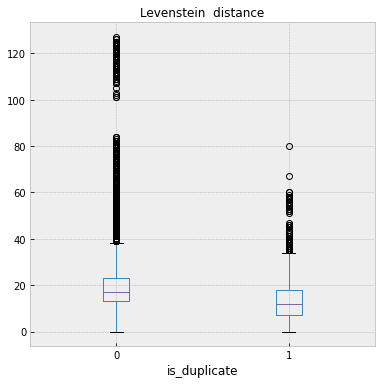

In [33]:
plt.figure(figsize=(6,6))

train.boxplot("levenstein", by="is_duplicate", ax=plt.gca())
plt.suptitle("")
plt.title("Levenstein  distance", fontsize=12);

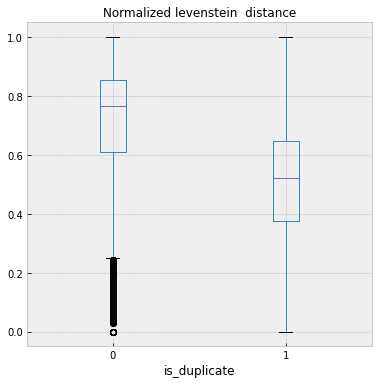

In [34]:
plt.figure(figsize=(6,6))

train.boxplot("norm_levenstein", by="is_duplicate", ax=plt.gca())
plt.suptitle("")
plt.title("Normalized levenstein  distance", fontsize=12);

# Базовая модель

In [35]:
FTS = ["levenstein", "norm_levenstein"]
THR = 0.9

In [36]:
split = StratifiedShuffleSplit(1, train_size=0.8, random_state=RS)
tridx, cvidx = list(split.split(train[FTS], train["is_duplicate"]))[0]

In [37]:
model = LogisticRegression(class_weight="balanced")
model.fit(train.iloc[tridx][FTS].values,
          train.iloc[tridx]["is_duplicate"].values)

LogisticRegression(class_weight='balanced')

In [38]:
tr_preds = model.predict_proba(train.iloc[tridx][FTS].values)
cv_preds = model.predict_proba(train.iloc[cvidx][FTS].values)

In [39]:
tr_preds = (tr_preds[:, 1] > THR).astype(np.int)
cv_preds = (cv_preds[:, 1] > THR).astype(np.int)

In [40]:
print(classification_report(train.iloc[tridx]["is_duplicate"].values, tr_preds))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    395329
           1       0.17      0.13      0.15      2926

    accuracy                           0.99    398255
   macro avg       0.58      0.56      0.57    398255
weighted avg       0.99      0.99      0.99    398255



In [41]:
print(classification_report(train.iloc[cvidx]["is_duplicate"].values, cv_preds))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     98832
           1       0.17      0.14      0.15       732

    accuracy                           0.99     99564
   macro avg       0.58      0.57      0.57     99564
weighted avg       0.99      0.99      0.99     99564



In [42]:
print(f1_score(train.iloc[tridx]["is_duplicate"].values, tr_preds))
print(f1_score(train.iloc[cvidx]["is_duplicate"].values, cv_preds))

0.14792338327327895
0.15128593040847202


# Генерация сабмита

In [43]:
sample_sub = pd.read_csv(DATA_DIR.joinpath("sample_submission.csv"), index_col="pair_id")

In [44]:
sample_sub

,is_duplicate
pair_id,
1,1
2,1
3,1
4,1
5,1
...,...
213245,1
213246,1
213247,1


In [45]:
sample_sub["is_duplicate"] = (model.predict_proba(test[FTS].values)[:, 1] > THR).astype(np.int)

In [46]:
sample_sub.is_duplicate.value_counts()

0    211968
1      1281
Name: is_duplicate, dtype: int64

In [47]:
sample_sub.to_csv(DATA_DIR.joinpath("baseline_submission.csv"))